IMPORTACIÓN DE LIBRERÍAS Y DATOS
Se obtiene una lista de las columnas del dataset, con qué tipo de datos contiene y cuantos nulos hay

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree

df = pd.read_csv('Barcelona_Fotocasa_HousingPrices.csv')

print(f'El dataset original contiene {df.shape[0]} filas y {df.shape[1]} columnas')
print('-' * 30)

print('Un resumen de los tipos de datos del dataset es:')
for i, columna in enumerate(df.columns):
    tipo_dato = df[columna].dtype
    nulos = df[columna].isnull().sum()  # Conteo de nulos específico para cada columna
    if df[columna].dtype == 'int64':
        ceros = df[columna].value_counts().get(0, 0)  # Devuelve 0 si no hay ceros    
    print(f"Columna {i+1}: {columna} | Tipo de dato: {tipo_dato} | Contiene {nulos} nulos | Contiene {ceros} ceros")



El dataset original contiene 8188 filas y 10 columnas
------------------------------
Un resumen de los tipos de datos del dataset es:
Columna 1: Unnamed: 0 | Tipo de dato: int64 | Contiene 0 nulos | Contiene 1 ceros
Columna 2: price | Tipo de dato: int64 | Contiene 0 nulos | Contiene 0 ceros
Columna 3: rooms | Tipo de dato: int64 | Contiene 0 nulos | Contiene 204 ceros
Columna 4: bathroom | Tipo de dato: int64 | Contiene 0 nulos | Contiene 0 ceros
Columna 5: lift | Tipo de dato: bool | Contiene 0 nulos | Contiene 0 ceros
Columna 6: terrace | Tipo de dato: bool | Contiene 0 nulos | Contiene 0 ceros
Columna 7: square_meters | Tipo de dato: int64 | Contiene 0 nulos | Contiene 0 ceros
Columna 8: real_state | Tipo de dato: object | Contiene 268 nulos | Contiene 0 ceros
Columna 9: neighborhood | Tipo de dato: object | Contiene 0 nulos | Contiene 0 ceros
Columna 10: square_meters_price | Tipo de dato: float64 | Contiene 0 nulos | Contiene 0 ceros


Eliminamos las filas que contienen 0 en la columna de habitaciones y no sea un estudio, y los nulos de la columna de real_state, ya que un piso con 0 habitaciones que no sea un estudio no es físicamente posible, y un nulo en real_state no puede saberse a qué tipo de vivienda se refiere, así que lo eliminamos.  

In [4]:
condicion = (
    (df['rooms'] == 0) & (df['real_state'] != 'study') |  # Condición 1: las filas donde las habitaciones sean 0 y que no sea "estudio"
    (df['real_state'].isnull())                           # Condición 2: las filas donde el "real_state" sea nulo 
)

df_cleaned = df[~condicion]                               # Nos quedamos con las filas que no cumplan las condiciones

print(f'El dataset filtrado con las condiciones seleccionadas tiene {df_cleaned.shape[0]} filas')

El dataset filtrado con las condiciones seleccionadas tiene 7819 filas


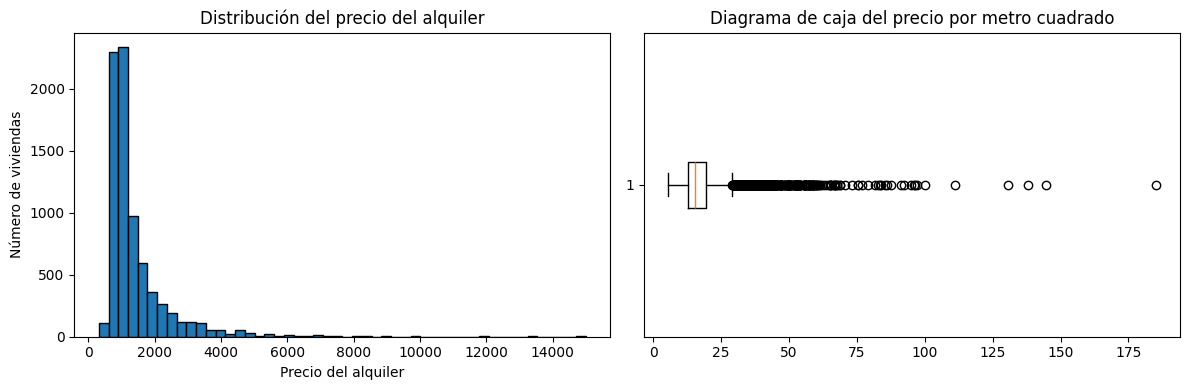

In [5]:
# Representamos la distribución del precio del alquiler

fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas

# En la columna 1, representaremos el histograma con los precios del df_cleaned
ax[0].hist(df_cleaned['price'], bins=50, edgecolor='black')
ax[0].set_title('Distribución del precio del alquiler')
ax[0].set_xlabel('Precio del alquiler')
ax[0].set_ylabel('Número de viviendas')

# En la columna 2, representaremos el diagrama de caja de todos los precios/m2 
ax[1].boxplot(df_cleaned['square_meters_price'], vert=False)
ax[1].set_title('Diagrama de caja del precio por metro cuadrado')

plt.tight_layout()

plt.show()

Con la distribución de todos los precios de los alquileres, vemos que la distribución está muy desplazada hacia los precios bajos. Esto se confirma leyendo el diagrama de caja, con una gran cantidad de putnos por entima del bigote derecho. 

Se realiza una eliminación de puntos atípicos para cada barrio, ya que si se realiza en el conjunto total de los datos, los barrios que tienen una media de alquiler superior, podrían verse más afectados que barrios en donde el alquiler es más bajo.

In [6]:
# Convertir columnas categóricas a variables dummy
df_dummies = pd.get_dummies(df_cleaned, drop_first=True)  # Elimina una categoría para evitar la multicolinealidad

# Ahora calcula la matriz de correlación
correlation_matrix = df_dummies.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


                                  Unnamed: 0     price     rooms  bathroom  \
Unnamed: 0                          1.000000 -0.009264 -0.040502 -0.038354   
price                              -0.009264  1.000000  0.348523  0.582286   
rooms                              -0.040502  0.348523  1.000000  0.583617   
bathroom                           -0.038354  0.582286  0.583617  1.000000   
lift                               -0.064000  0.054183  0.217349  0.214005   
terrace                            -0.077165  0.172341  0.131853  0.175437   
square_meters                      -0.057701  0.686061  0.674008  0.767815   
square_meters_price                 0.072264  0.530105 -0.247968 -0.014797   
real_state_attic                   -0.017198  0.119934  0.002968  0.068757   
real_state_flat                    -0.074670 -0.231975  0.182897  0.014829   
real_state_study                    0.018877 -0.074875 -0.201633 -0.072439   
neighborhood_Eixample               0.031185  0.089359  0.078023

In [7]:
# Esta función elimina los outliers de la variable del barrio del df_cleaned
def eliminar_outliers(df, barrio, columna ):
    df_barrio = df[df['neighborhood'] == barrio].copy()
    
    Q1 = df_barrio[columna].quantile(0.25)
    Q3 = df_barrio[columna].quantile(0.75)
    IQR = Q3 - Q1
    LS = Q3 + 1.5 * IQR

    outliers = df_barrio[df_barrio[columna] > LS]
    num_outliers = outliers.shape[0]  # Número de filas (outliers)

    print(f"Análisis para el barrio: {barrio}")
    print('Primer cuartil (Q1):', round(Q1, 2))
    print('Tercer cuartil (Q3):', round(Q3, 2))
    print('Rango intercuartílico (IQR):', round(IQR, 2))
    print(f"Número de outliers: {num_outliers}")
    print('-' * 30)  # Separador para mejor legibilidad

    df_sin_outliers = df_barrio[df_barrio[columna] <= LS]

    return df_sin_outliers

In [8]:
# Lista para almacenar los dataframes sin outliers de cada barrio
resultados = []

# Dataframe de todos los barrios que hay
barrios = df_cleaned['neighborhood'].unique()

for barrio in barrios:
    df_sin_outliers = eliminar_outliers(df_cleaned, barrio, 'square_meters_price')
    if df_sin_outliers is not None and not df_sin_outliers.empty:               # Solo añadir si hay datos válidos
        resultados.append(df_sin_outliers)

if resultados:
    df_final = pd.concat(resultados, ignore_index=True)                         # Concatenar los dataframes que contiene "resultados"
else:
    df_final = df_cleaned.copy()                                                # Crea un DataFrame vacío si no hay resultados

# Mostrar las filas de diferencia antes y después del filtrado
print(f'El dataframe final, habiendo filtrado errores en los datos y atípicos, contiene {df_final.shape[0]} filas y {df_final.shape[1]} columnas')
print(f'La reducción respecto al set inicial ha sido de {df.shape[0] - df_final.shape[0]} filas')


Análisis para el barrio: Horta- Guinardo
Primer cuartil (Q1): 11.02
Tercer cuartil (Q3): 14.94
Rango intercuartílico (IQR): 3.91
Número de outliers: 14
------------------------------
Análisis para el barrio: Sant Andreu
Primer cuartil (Q1): 11.08
Tercer cuartil (Q3): 13.96
Rango intercuartílico (IQR): 2.87
Número de outliers: 10
------------------------------
Análisis para el barrio: Gràcia
Primer cuartil (Q1): 12.5
Tercer cuartil (Q3): 18.28
Rango intercuartílico (IQR): 5.78
Número de outliers: 52
------------------------------
Análisis para el barrio: Ciutat Vella
Primer cuartil (Q1): 13.68
Tercer cuartil (Q3): 21.25
Rango intercuartílico (IQR): 7.57
Número de outliers: 92
------------------------------
Análisis para el barrio: Sarria-Sant Gervasi
Primer cuartil (Q1): 13.53
Tercer cuartil (Q3): 19.23
Rango intercuartílico (IQR): 5.7
Número de outliers: 91
------------------------------
Análisis para el barrio: Les Corts
Primer cuartil (Q1): 12.77
Tercer cuartil (Q3): 17.5
Rango inter

En la secuencia superior del código, se muestran los resultados de cuantos outliers se han eliminado por cada barrio y las dimensiones finales del dataframe post-tratamiento, que son 7600 filas, y las 10 columnas iniciales. 

In [9]:
for i, columna in enumerate(df_final.columns):
    tipo_dato = df_final[columna].dtype
    nulos = df_final[columna].isnull().sum()  # Conteo de nulos específico para cada columna
    if df_final[columna].dtype == 'int64':
        ceros = df_final[columna].value_counts().get(0, 0)  # Devuelve 0 si no hay ceros    
    print(f"Columna {i+1}: {columna} | Tipo de dato: {tipo_dato} | Contiene {nulos} nulos | Contiene {ceros} ceros")

Columna 1: Unnamed: 0 | Tipo de dato: int64 | Contiene 0 nulos | Contiene 1 ceros
Columna 2: price | Tipo de dato: int64 | Contiene 0 nulos | Contiene 0 ceros
Columna 3: rooms | Tipo de dato: int64 | Contiene 0 nulos | Contiene 45 ceros
Columna 4: bathroom | Tipo de dato: int64 | Contiene 0 nulos | Contiene 0 ceros
Columna 5: lift | Tipo de dato: bool | Contiene 0 nulos | Contiene 0 ceros
Columna 6: terrace | Tipo de dato: bool | Contiene 0 nulos | Contiene 0 ceros
Columna 7: square_meters | Tipo de dato: int64 | Contiene 0 nulos | Contiene 0 ceros
Columna 8: real_state | Tipo de dato: object | Contiene 0 nulos | Contiene 0 ceros
Columna 9: neighborhood | Tipo de dato: object | Contiene 0 nulos | Contiene 0 ceros
Columna 10: square_meters_price | Tipo de dato: float64 | Contiene 0 nulos | Contiene 0 ceros


Con esta secuencia se observa una limpieza total de los datos. Ahora no hay 0 sin explicación, nulos, ni outliers.
Los 0 que hay es porque son estudios, viviendas que pueden considerarse que son de 0 habitaciones por su naturaleza habierta. 

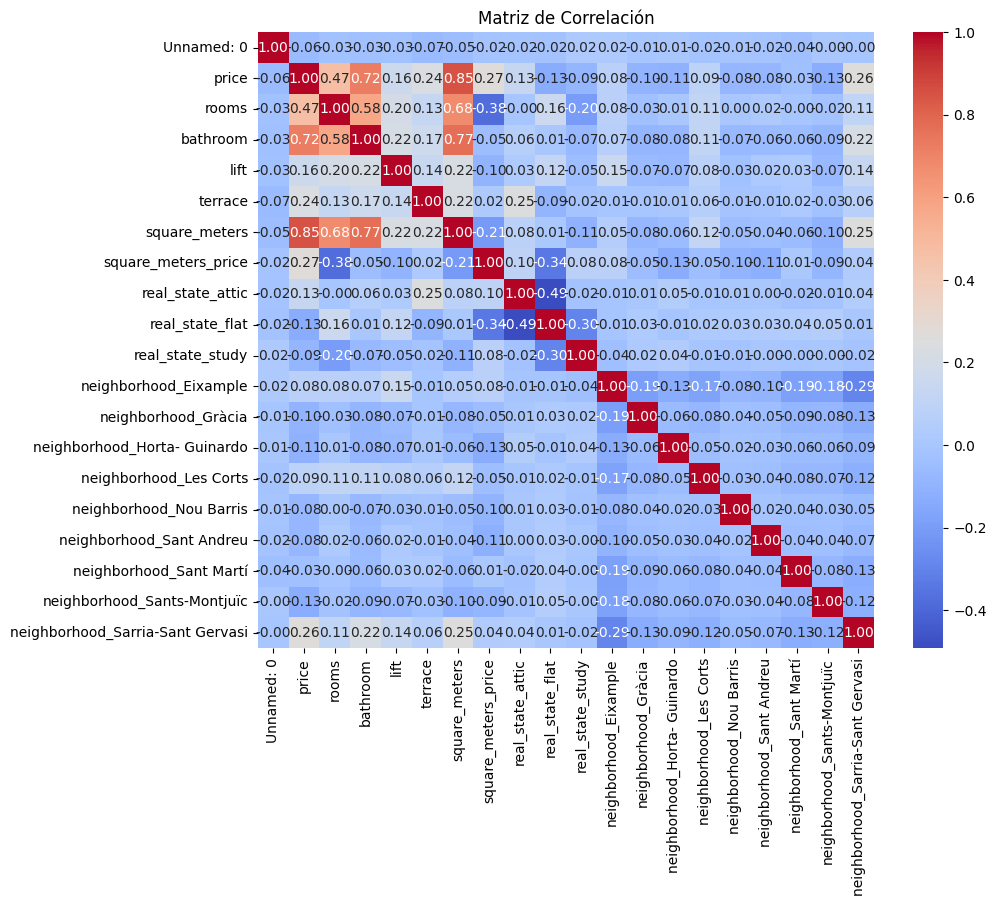

In [10]:
# Convertir columnas categóricas a variables dummy para poder representarlas en la matriz de correlación
df_dummies = pd.get_dummies(df_final, drop_first=True) 

# Calcula la matriz de correlación
correlation_matrix = df_dummies.corr()

# Representa la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

El RMSE del modelo es: 0.99827
El R² del modelo es: 0.99655
square_meters                       7.552729e-01
square_meters_price                 2.415464e-01
bathroom                            1.441005e-03
rooms                               5.469737e-04
real_state_attic                    2.256708e-04
neighborhood_Eixample               1.699962e-04
real_state_flat                     1.569841e-04
terrace                             1.481380e-04
neighborhood_Sarria-Sant Gervasi    1.317746e-04
lift                                8.171909e-05
real_state_apartment                7.672695e-05
neighborhood_Ciutat Vella           6.498888e-05
neighborhood_Les Corts              6.246991e-05
neighborhood_Sant Martí             4.098214e-05
neighborhood_Gràcia                 1.644897e-05
neighborhood_Sants-Montjuïc         6.509584e-06
neighborhood_Horta- Guinardo        3.867175e-06
real_state_study                    3.756849e-06
neighborhood_Sant Andreu            1.894844e-06
neighborh

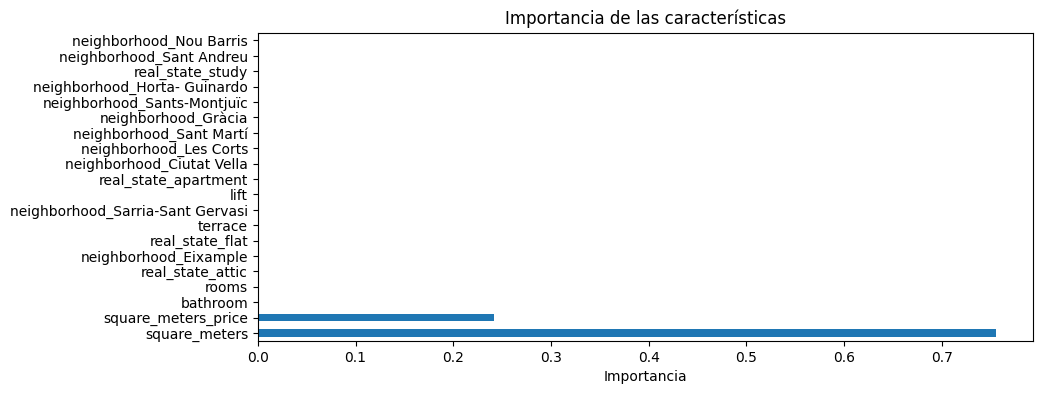

In [11]:
# Procesamiento de datos
df_final['lift'] = df_final['lift'].astype(bool)        # Convertir a bool explícitamente
df_final['terrace'] = df_final['terrace'].astype(bool)  # Convertir a bool explícitamente

df_final['lift'] = df_final['lift'].astype(int)         # Convertir bool a int
df_final['terrace'] = df_final['terrace'].astype(int)   # Convertir bool a int

# Dividir los datos en características (X) y variable objetivo (y)
X = df_final.drop(columns=['Unnamed: 0', 'price'])    # Variables independientes
y = df_final['price']                   # Variable dependiente

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un preprocesador que maneje las variables categóricas
categorica = ['real_state', 'neighborhood']
numerica = ['rooms', 'bathroom', 'lift', 'terrace', 'square_meters', 'square_meters_price']

preprocessor = ColumnTransformer(
    transformers = [
        ('num', 'passthrough', numerica),       # Pasar las columnas numéricas
        ('cat', OneHotEncoder(), categorica)    # One-Hot Encoding para las categóricas
    ])

# Crear un pipeline con el preprocesador y el modelo
modelo = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entrenar el modelo y realizar las predicciones
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Evaluar el modelo
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(r2)

print(f"El RMSE del modelo es: {round(rmse,5)}")
print(f"El R² del modelo es: {round(r2,5)}")

# Importancia de las características
importancias = modelo.named_steps['model'].feature_importances_
feature_names = numerica + list(modelo.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorica))

# Mostrar la importancia de las características
df_importancias = pd.Series(importancias, index=feature_names).sort_values(ascending=False)
print(df_importancias)

plt.figure(figsize=(10, 4))
df_importancias.plot(kind='barh')
plt.title('Importancia de las características')
plt.xlabel('Importancia')
print('A continuación se muestra el gráfico de las importancias:')
plt.show()


Con el gráfico de las importancias, vemos qué factores afectan más al modelo: en este caso claramente los metros cuadrados destacan por encima del resto, con una importancia de 0.816

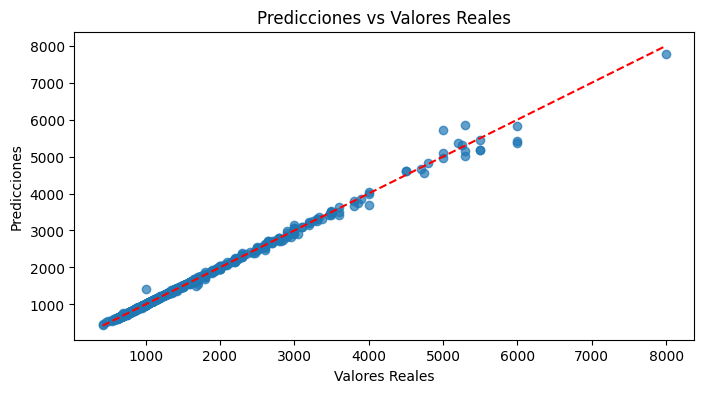

In [12]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

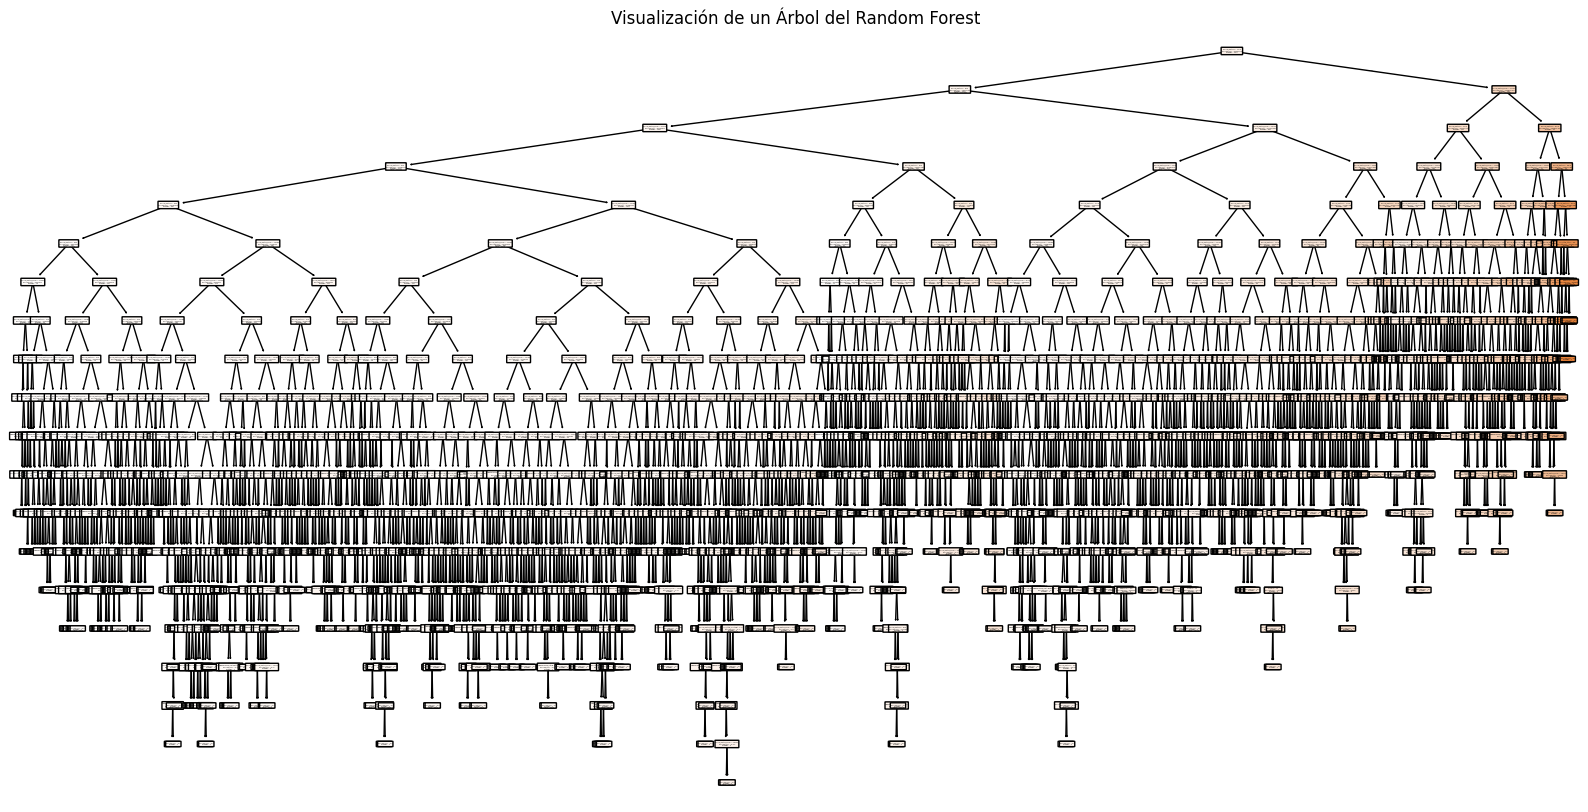

In [13]:
# Visualizar el primer árbol del bosque
plt.figure(figsize=(20, 10))
plot_tree(modelo.named_steps['model'].estimators_[0], 
          feature_names=feature_names, 
          filled=True, 
          rounded=True)
plt.title('Visualización de un Árbol del Random Forest')
plt.show()

El arnbol del modelo RandomForest para nuestro caso concreto

In [15]:
import pandas as pd
nuevos_datos = pd.DataFrame({
    'rooms': [4],
    'bathroom': [2],
    'lift': [True],
    'terrace': [False],
    'real_state': ['flat'],
    'neighborhood': ['Nou Barris'],
    'square_meters': [50],
    'square_meters_price': [30]
})

predicciones = modelo.predict(nuevos_datos)

print(f'El precio de la vivienda propuesta serà de {predicciones[0]}€')

El precio de la vivienda propuesta serà de 1499.5€


In [ ]:
# División de los datos en train y test
# ==============================================================================
X = df_final[['bateos']]
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
     

# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())
     

# Predicciones con intervalo de confianza del 95%
# ==============================================================================
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train[:, 1]
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
ax.legend();